# 05 - Prediction Generation: MSFT Trading Signals

This notebook loads the trained classification model, generates **buy/sell/hold** predictions for MSFT stock, calculates confidence scores, and stores results in the Gold layer.

## Objectives:
- Load trained XGBoost model from disk
- Prepare latest feature data from Gold layer
- Generate predictions with probability scores
- Map signals: Buy (1), Hold (0), Sell (-1)
- Store predictions in Gold layer for Power BI

## Prerequisites:
- Run notebooks 01-04 first
- Trained model saved at `../models/msft_xgboost_classifier.pkl`

## Step 1: Import Libraries and Initialize

Load required modules and configuration

In [2]:
# Import required libraries
import sys
import json
import pandas as pd
import importlib
from datetime import datetime
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent / 'utils'))

# Force reload to pick up changes
if 'models' in sys.modules:
    importlib.reload(sys.modules['models'])

from models import StockClassifier  # type: ignore

# Load config
config_path = Path.cwd().parent / 'config' / 'config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

TICKER = config['data_source']['tickers'][0]
GOLD_PATH = Path.cwd().parent / 'data' / 'gold' / 'stocks'
PREDICTIONS_PATH = Path.cwd().parent / 'data' / 'gold' / 'predictions'
MODEL_PATH = Path.cwd().parent / 'models' / 'msft_xgboost_classifier.pkl'

print("✓ Libraries imported")
print(f"  Ticker: {TICKER}")
print(f"  Execution time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Libraries imported
  Ticker: MSFT
  Execution time: 2025-12-04 17:51:31


## Step 2: Load Trained Model

Load the XGBoost classifier from disk. If model doesn't exist, exit gracefully.

In [3]:
# Load trained model
config_path = Path.cwd().parent / 'config' / 'config.json'
classifier = StockClassifier(config_path=str(config_path))

if not MODEL_PATH.exists():
    print(f"⚠ Model not found at {MODEL_PATH}")
    print("  Please run notebook 04_model_training.ipynb first!")
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

classifier.load_model(str(MODEL_PATH))

print(f"  Features expected: {len(classifier.feature_columns)}")
print(f"  Feature columns: {classifier.feature_columns[:5]}...")

✓ Model loaded from msft_xgboost_classifier.pkl
  Features expected: 57
  Feature columns: ['SMA_20', 'SMA_50', 'SMA_200', 'EMA_12', 'EMA_26']...


## Step 3: Load Gold Layer Features

Load the latest feature data with technical indicators

In [4]:
# Load Gold layer features
gold_file = GOLD_PATH / f'{TICKER}_features.parquet'

if not gold_file.exists():
    print(f"⚠ Gold features not found at {gold_file}")
    print("  Please run notebook 03_feature_engineering.ipynb first!")
    raise FileNotFoundError(f"Features file not found: {gold_file}")

df = pd.read_parquet(gold_file)

print(f"✓ Loaded Gold features: {len(df)} rows")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Columns: {len(df.columns)}")

✓ Loaded Gold features: 1489 rows
  Date range: 2020-01-02 00:00:00-05:00 to 2025-12-03 00:00:00-05:00
  Columns: 90


## Step 4: Prepare Features for Prediction

Align feature columns with what the model expects

In [11]:
# Prepare features - ensure all required columns exist
required_features = classifier.feature_columns
missing_features = [f for f in required_features if f not in df.columns]

if missing_features:
    print(f"⚠ Missing features: {missing_features}")
    raise ValueError(f"Missing required features: {missing_features}")

# Select only rows with valid features (no NaN in required columns)
df_valid = df.dropna(subset=required_features)
print(f"✓ Valid rows for prediction: {len(df_valid)} (dropped {len(df) - len(df_valid)} with NaN)")

# Get feature matrix
X = df_valid[required_features].copy()
print(f"  Feature matrix shape: {X.shape}")

✓ Valid rows for prediction: 737 (dropped 752 with NaN)
  Feature matrix shape: (737, 57)


## Step 5: Generate Predictions

Run inference and calculate confidence scores

In [12]:
# Generate predictions
predictions, probabilities = classifier.predict(X)

# Create predictions dataframe
df_predictions = df_valid[['date', 'close']].copy()
df_predictions['prediction'] = predictions
df_predictions['prob_sell'] = probabilities[:, 0]   # Class -1
df_predictions['prob_hold'] = probabilities[:, 1]   # Class 0
df_predictions['prob_buy'] = probabilities[:, 2]    # Class 1

# Map prediction to signal name
signal_map = {-1: 'SELL', 0: 'HOLD', 1: 'BUY'}
df_predictions['signal'] = df_predictions['prediction'].map(signal_map)

# Calculate confidence as max probability
df_predictions['confidence'] = probabilities.max(axis=1)

# Add metadata
df_predictions['ticker'] = TICKER
df_predictions['prediction_date'] = datetime.now()

print(f"✓ Generated {len(df_predictions)} predictions")
print("\nSignal Distribution:")
print(df_predictions['signal'].value_counts())

✓ Generated 737 predictions

Signal Distribution:
signal
HOLD    527
BUY     112
SELL     98
Name: count, dtype: int64


## Step 6: Latest Signal Dashboard

Display the most recent prediction and summary statistics

In [7]:
# Latest signal dashboard
latest = df_predictions.iloc[-1]

print("="*60)
print(f"📊 LATEST TRADING SIGNAL - {TICKER}")
print("="*60)
print(f"  Date:       {latest['date']}")
print(f"  Close:      ${latest['close']:.2f}")
print(f"  Signal:     {latest['signal']}")
print(f"  Confidence: {latest['confidence']*100:.1f}%")
print("-"*60)
print("  Probabilities:")
print(f"    BUY:  {latest['prob_buy']*100:.1f}%")
print(f"    HOLD: {latest['prob_hold']*100:.1f}%")
print(f"    SELL: {latest['prob_sell']*100:.1f}%")
print("="*60)

# Last 10 predictions
print("\n📈 Recent Predictions (Last 10 Days):")
recent = df_predictions[['date', 'close', 'signal', 'confidence']].tail(10)
recent['confidence'] = (recent['confidence'] * 100).round(1).astype(str) + '%'
print(recent.to_string(index=False))

📊 LATEST TRADING SIGNAL - MSFT
  Date:       2025-12-03 00:00:00-05:00
  Close:      $477.73
  Signal:     HOLD
  Confidence: 73.6%
------------------------------------------------------------
  Probabilities:
    BUY:  9.3%
    HOLD: 73.6%
    SELL: 17.1%

📈 Recent Predictions (Last 10 Days):
                     date      close signal confidence
2025-10-24 00:00:00-04:00 522.631836    BUY      54.1%
2025-10-27 00:00:00-04:00 530.527100   HOLD      85.5%
2025-10-28 00:00:00-04:00 541.057373   HOLD      93.6%
2025-10-29 00:00:00-04:00 540.538330   HOLD      87.4%
2025-10-30 00:00:00-04:00 524.777832   HOLD      89.7%
2025-11-26 00:00:00-05:00 485.500000   HOLD      80.1%
2025-11-28 00:00:00-05:00 492.010010   HOLD      90.4%
2025-12-01 00:00:00-05:00 486.739990   HOLD      86.3%
2025-12-02 00:00:00-05:00 490.000000   HOLD      86.6%
2025-12-03 00:00:00-05:00 477.730011   HOLD      73.6%


## Step 7: Visualize Predictions

Plot price with buy/sell signals overlay

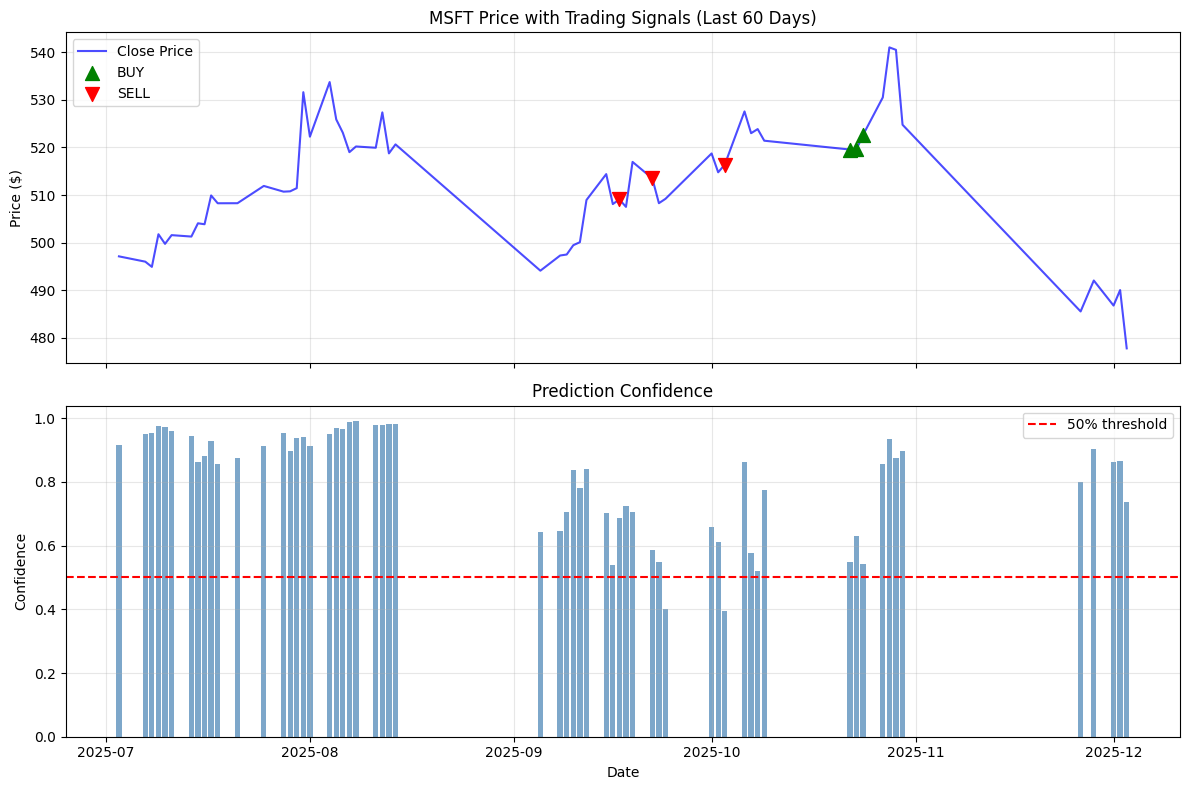

✓ Chart saved to data\predictions_chart.png


In [8]:
import matplotlib.pyplot as plt

# Plot last 60 days of predictions
plot_df = df_predictions.tail(60).copy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Price chart with signals
ax1.plot(plot_df['date'], plot_df['close'], 'b-', label='Close Price', alpha=0.7)

# Mark buy signals
buy_mask = plot_df['prediction'] == 1
ax1.scatter(plot_df.loc[buy_mask, 'date'], plot_df.loc[buy_mask, 'close'], 
            c='green', marker='^', s=100, label='BUY', zorder=5)

# Mark sell signals
sell_mask = plot_df['prediction'] == -1
ax1.scatter(plot_df.loc[sell_mask, 'date'], plot_df.loc[sell_mask, 'close'], 
            c='red', marker='v', s=100, label='SELL', zorder=5)

ax1.set_ylabel('Price ($)')
ax1.set_title(f'{TICKER} Price with Trading Signals (Last 60 Days)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Confidence chart
ax2.bar(plot_df['date'], plot_df['confidence'], color='steelblue', alpha=0.7)
ax2.axhline(y=0.5, color='red', linestyle='--', label='50% threshold')
ax2.set_ylabel('Confidence')
ax2.set_xlabel('Date')
ax2.set_title('Prediction Confidence')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
chart_path = Path.cwd().parent / 'data' / 'predictions_chart.png'
chart_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(chart_path, dpi=150)
plt.show()

print(f"✓ Chart saved to {chart_path.relative_to(Path.cwd().parent)}")

## Step 8: Store Predictions in Gold Layer

Save predictions for Power BI consumption

In [9]:
# Create predictions output directory
PREDICTIONS_PATH.mkdir(parents=True, exist_ok=True)

# Save full predictions history
output_file = PREDICTIONS_PATH / f'{TICKER}_predictions.parquet'
df_predictions.to_parquet(output_file, index=False)

# Also save latest prediction as separate file (for dashboard quick access)
latest_file = PREDICTIONS_PATH / f'{TICKER}_latest.parquet'
df_predictions.tail(1).to_parquet(latest_file, index=False)

print("✓ Predictions saved:")
print(f"  Full history: {output_file.name} ({len(df_predictions)} records)")
print(f"  Latest only:  {latest_file.name}")

✓ Predictions saved:
  Full history: MSFT_predictions.parquet (737 records)
  Latest only:  MSFT_latest.parquet


## Step 9: Summary Statistics

Review prediction quality and signal balance

In [10]:
# Summary statistics
print("="*60)
print("📊 PREDICTION SUMMARY")
print("="*60)

# Signal distribution
signal_counts = df_predictions['signal'].value_counts()
total = len(df_predictions)
print("\nSignal Distribution:")
for signal, count in signal_counts.items():
    pct = count / total * 100
    print(f"  {signal}: {count:,} ({pct:.1f}%)")

# Confidence statistics
print("\nConfidence Statistics:")
print(f"  Mean:   {df_predictions['confidence'].mean()*100:.1f}%")
print(f"  Median: {df_predictions['confidence'].median()*100:.1f}%")
print(f"  Min:    {df_predictions['confidence'].min()*100:.1f}%")
print(f"  Max:    {df_predictions['confidence'].max()*100:.1f}%")

# High confidence signals (>70%)
high_conf = df_predictions[df_predictions['confidence'] > 0.7]
print(f"\nHigh Confidence Signals (>70%): {len(high_conf)} ({len(high_conf)/total*100:.1f}%)")

print("="*60)

📊 PREDICTION SUMMARY

Signal Distribution:
  HOLD: 527 (71.5%)
  BUY: 112 (15.2%)
  SELL: 98 (13.3%)

Confidence Statistics:
  Mean:   93.6%
  Median: 97.4%
  Min:    38.0%
  Max:    99.9%

High Confidence Signals (>70%): 703 (95.4%)


## Next Steps

1. **Run Notebook 06**: Monte Carlo simulation for price forecasting
2. **Power BI**: Connect to `gold/predictions/MSFT_predictions.parquet` for dashboards

---
**Note**: Re-run this notebook daily after market close to update predictions.